In [3]:
import torch
import pandas as pd
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import random
import timeit
from tqdm import tqdm

In [4]:
RANDOM_SEED = 42
BATCH_SIZE = 512
EPOCHS = 40
LEARNING_RATE = 1e-4
NUM_CLASSES = 10
PATCH_SIZE = 4
IMG_SIZE = 28
IN_CHANNELS = 1
NUM_HEADS = 8
DROPOUT = 0.001
HIDDEN_DIM = 768
ADAM_WEIGHT_DECAY = 0
ADAM_BETAS = (0.9, 0.999)
ACTIVATION="gelu"
NUM_ENCODERS = 4
EMBED_DIM = (PATCH_SIZE ** 2) * IN_CHANNELS # 16
NUM_PATCHES = (IMG_SIZE // PATCH_SIZE) ** 2 # 49

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
class PatchEmbedding(nn.Module):
    def __init__(self, embed_dim, patch_size, num_patches, dropout, in_channels):
        super().__init__()
        self.patcher = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=embed_dim,
                kernel_size=patch_size,
                stride=patch_size,
            ),                  
            nn.Flatten(2))

        self.cls_token = nn.Parameter(torch.randn(size=(1, in_channels, embed_dim)), requires_grad=True)
        self.position_embeddings = nn.Parameter(torch.randn(size=(1, num_patches+1, embed_dim)), requires_grad=True)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        cls_token = self.cls_token.expand(x.shape[0], -1, -1)

        x = self.patcher(x).permute(0, 2, 1)
        x = torch.cat([cls_token, x], dim=1)
        x = self.position_embeddings + x 
        x = self.dropout(x)
        return x
    
model = PatchEmbedding(EMBED_DIM, PATCH_SIZE, NUM_PATCHES, DROPOUT, IN_CHANNELS).to(device)
x = torch.randn(512, 1, 28, 28).to(device)
print(model(x).shape)

torch.Size([512, 50, 16])


In [6]:
class ViT(nn.Module):
    def __init__(self, num_patches, img_size, num_classes, patch_size, embed_dim, num_encoders, num_heads, hidden_dim, dropout, activation, in_channels):
        super().__init__()
        self.embeddings_block = PatchEmbedding(embed_dim, patch_size, num_patches, dropout, in_channels)
        
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dropout=dropout, activation=activation, batch_first=True, norm_first=True)
        self.encoder_blocks = nn.TransformerEncoder(encoder_layer, num_layers=num_encoders)

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(normalized_shape=embed_dim),
            nn.Linear(in_features=embed_dim, out_features=num_classes)
        )

    def forward(self, x):
        x = self.embeddings_block(x)
        x = self.encoder_blocks(x)
        x = self.mlp_head(x[:, 0, :])  # Apply MLP on the CLS token only
        return x

model = ViT(NUM_PATCHES, IMG_SIZE, NUM_CLASSES, PATCH_SIZE, EMBED_DIM, NUM_ENCODERS, NUM_HEADS, HIDDEN_DIM, DROPOUT, ACTIVATION, IN_CHANNELS).to(device)
x = torch.randn(512, 1, 28, 28).to(device)
print(model(x).shape) # BATCH_SIZE X NUM_CLASSES

c:\Users\madha\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


torch.Size([512, 10])


c:\Users\madha\anaconda3\Lib\site-packages\torch\nn\functional.py:5560: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


In [7]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")


In [8]:
train_df.head(), test_df.head()

(   label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
 0      1       0       0       0       0       0       0       0       0   
 1      0       0       0       0       0       0       0       0       0   
 2      1       0       0       0       0       0       0       0       0   
 3      4       0       0       0       0       0       0       0       0   
 4      0       0       0       0       0       0       0       0       0   
 
    pixel8  ...  pixel774  pixel775  pixel776  pixel777  pixel778  pixel779  \
 0       0  ...         0         0         0         0         0         0   
 1       0  ...         0         0         0         0         0         0   
 2       0  ...         0         0         0         0         0         0   
 3       0  ...         0         0         0         0         0         0   
 4       0  ...         0         0         0         0         0         0   
 
    pixel780  pixel781  pixel782  pixel783  
 0         0   

In [11]:
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=RANDOM_SEED, shuffle=True)

In [12]:
class MNISTTrainDataset(Dataset):
    def __init__(self, images, labels, indicies):
        self.images = images
        self.labels = labels
        self.indicies = indicies
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomRotation(15),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx].reshape((28, 28)).astype(np.uint8)
        label = self.labels[idx]
        index = self.indicies[idx]
        image = self.transform(image)
        
        return {"image": image, "label": label, "index": index}
    
class MNISTValDataset(Dataset):
    def __init__(self, images, labels, indicies):
        self.images = images
        self.labels = labels
        self.indicies = indicies
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx].reshape((28, 28)).astype(np.uint8)
        label = self.labels[idx]
        index = self.indicies[idx]
        image = self.transform(image)
        
        return {"image": image, "label": label, "index": index}
    
class MNISTSubmitDataset(Dataset):
    def __init__(self, images, indicies):
        self.images = images
        self.indicies = indicies
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx].reshape((28, 28)).astype(np.uint8)
        index = self.indicies[idx]
        image = self.transform(image)
        
        return {"image": image, "index": index}

In [14]:
train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

val_dataloader = DataLoader(dataset=val_dataset,
                            batch_size=BATCH_SIZE,
                            shuffle=True)

test_dataloader = DataLoader(dataset=test_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), betas=ADAM_BETAS, lr=LEARNING_RATE, weight_decay=ADAM_WEIGHT_DECAY)

start = timeit.default_timer()
for epoch in tqdm(range(EPOCHS), position=0, leave=True):
    model.train()
    train_labels = []
    train_preds = []
    train_running_loss = 0
    for idx, img_label in enumerate(tqdm(train_dataloader, position=0, leave=True)):
        img = img_label["image"].float().to(device)
        label = img_label["label"].type(torch.uint8).to(device)
        y_pred = model(img)
        y_pred_label = torch.argmax(y_pred, dim=1)

        train_labels.extend(label.cpu().detach())
        train_preds.extend(y_pred_label.cpu().detach())
        
        loss = criterion(y_pred, label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_running_loss += loss.item()
    train_loss = train_running_loss / (idx + 1)

    model.eval()
    val_labels = []
    val_preds = []
    val_running_loss = 0
    with torch.no_grad():
        for idx, img_label in enumerate(tqdm(val_dataloader, position=0, leave=True)):
            img = img_label["image"].float().to(device)
            label = img_label["label"].type(torch.uint8).to(device)         
            y_pred = model(img)
            y_pred_label = torch.argmax(y_pred, dim=1)
            
            val_labels.extend(label.cpu().detach())
            val_preds.extend(y_pred_label.cpu().detach())
            
            loss = criterion(y_pred, label)
            val_running_loss += loss.item()
    val_loss = val_running_loss / (idx + 1)

    print("-"*30)
    print(f"Train Loss EPOCH {epoch+1}: {train_loss:.4f}")
    print(f"Valid Loss EPOCH {epoch+1}: {val_loss:.4f}")
    print(f"Train Accuracy EPOCH {epoch+1}: {sum(1 for x,y in zip(train_preds, train_labels) if x == y) / len(train_labels):.4f}")
    print(f"Valid Accuracy EPOCH {epoch+1}: {sum(1 for x,y in zip(val_preds, val_labels) if x == y) / len(val_labels):.4f}")
    print("-"*30)

stop = timeit.default_timer()
print(f"Training Time: {stop-start:.2f}s")

  2%|▎         | 1/40 [00:14<09:18, 14.33s/it]

------------------------------
Train Loss EPOCH 1: 2.2572
Valid Loss EPOCH 1: 2.0960
Train Accuracy EPOCH 1: 0.1602
Valid Accuracy EPOCH 1: 0.2443
------------------------------


  5%|▌         | 2/40 [00:27<08:45, 13.84s/it]

------------------------------
Train Loss EPOCH 2: 2.0125
Valid Loss EPOCH 2: 1.8174
Train Accuracy EPOCH 2: 0.2683
Valid Accuracy EPOCH 2: 0.3631
------------------------------


  8%|▊         | 3/40 [00:41<08:29, 13.76s/it]

------------------------------
Train Loss EPOCH 3: 1.7128
Valid Loss EPOCH 3: 1.5308
Train Accuracy EPOCH 3: 0.4146
Valid Accuracy EPOCH 3: 0.5140
------------------------------


 10%|█         | 4/40 [00:55<08:18, 13.85s/it]

------------------------------
Train Loss EPOCH 4: 1.5355
Valid Loss EPOCH 4: 1.4340
Train Accuracy EPOCH 4: 0.4928
Valid Accuracy EPOCH 4: 0.5531
------------------------------


 12%|█▎        | 5/40 [01:09<08:00, 13.74s/it]

------------------------------
Train Loss EPOCH 5: 1.4127
Valid Loss EPOCH 5: 1.2704
Train Accuracy EPOCH 5: 0.5447
Valid Accuracy EPOCH 5: 0.6167
------------------------------


 15%|█▌        | 6/40 [01:22<07:44, 13.66s/it]

------------------------------
Train Loss EPOCH 6: 1.2923
Valid Loss EPOCH 6: 1.1407
Train Accuracy EPOCH 6: 0.6053
Valid Accuracy EPOCH 6: 0.6800
------------------------------


 18%|█▊        | 7/40 [01:36<07:29, 13.61s/it]

------------------------------
Train Loss EPOCH 7: 1.1797
Valid Loss EPOCH 7: 1.0441
Train Accuracy EPOCH 7: 0.6620
Valid Accuracy EPOCH 7: 0.7336
------------------------------


 20%|██        | 8/40 [01:49<07:15, 13.60s/it]

------------------------------
Train Loss EPOCH 8: 1.0743
Valid Loss EPOCH 8: 0.9678
Train Accuracy EPOCH 8: 0.7113
Valid Accuracy EPOCH 8: 0.7505
------------------------------


 22%|██▎       | 9/40 [02:03<07:00, 13.57s/it]

------------------------------
Train Loss EPOCH 9: 0.9882
Valid Loss EPOCH 9: 0.8757
Train Accuracy EPOCH 9: 0.7376
Valid Accuracy EPOCH 9: 0.7850
------------------------------


 25%|██▌       | 10/40 [02:16<06:47, 13.60s/it]

------------------------------
Train Loss EPOCH 10: 0.9143
Valid Loss EPOCH 10: 0.8043
Train Accuracy EPOCH 10: 0.7562
Valid Accuracy EPOCH 10: 0.7983
------------------------------


 28%|██▊       | 11/40 [02:30<06:34, 13.62s/it]

------------------------------
Train Loss EPOCH 11: 0.8526
Valid Loss EPOCH 11: 0.7483
Train Accuracy EPOCH 11: 0.7718
Valid Accuracy EPOCH 11: 0.8167
------------------------------


 30%|███       | 12/40 [02:44<06:21, 13.63s/it]

------------------------------
Train Loss EPOCH 12: 0.8070
Valid Loss EPOCH 12: 0.7081
Train Accuracy EPOCH 12: 0.7861
Valid Accuracy EPOCH 12: 0.8310
------------------------------


 32%|███▎      | 13/40 [02:57<06:09, 13.69s/it]

------------------------------
Train Loss EPOCH 13: 0.7653
Valid Loss EPOCH 13: 0.6794
Train Accuracy EPOCH 13: 0.7957
Valid Accuracy EPOCH 13: 0.8321
------------------------------


 35%|███▌      | 14/40 [03:11<05:56, 13.72s/it]

------------------------------
Train Loss EPOCH 14: 0.7314
Valid Loss EPOCH 14: 0.6717
Train Accuracy EPOCH 14: 0.8042
Valid Accuracy EPOCH 14: 0.8164
------------------------------


 38%|███▊      | 15/40 [03:25<05:42, 13.70s/it]

------------------------------
Train Loss EPOCH 15: 0.6823
Valid Loss EPOCH 15: 0.5867
Train Accuracy EPOCH 15: 0.8195
Valid Accuracy EPOCH 15: 0.8571
------------------------------


 40%|████      | 16/40 [03:39<05:29, 13.71s/it]

------------------------------
Train Loss EPOCH 16: 0.6547
Valid Loss EPOCH 16: 0.5721
Train Accuracy EPOCH 16: 0.8274
Valid Accuracy EPOCH 16: 0.8626
------------------------------


 42%|████▎     | 17/40 [03:52<05:15, 13.73s/it]

------------------------------
Train Loss EPOCH 17: 0.6228
Valid Loss EPOCH 17: 0.5484
Train Accuracy EPOCH 17: 0.8367
Valid Accuracy EPOCH 17: 0.8698
------------------------------


 45%|████▌     | 18/40 [04:07<05:04, 13.85s/it]

------------------------------
Train Loss EPOCH 18: 0.5886
Valid Loss EPOCH 18: 0.5193
Train Accuracy EPOCH 18: 0.8444
Valid Accuracy EPOCH 18: 0.8717
------------------------------


 48%|████▊     | 19/40 [04:20<04:51, 13.87s/it]

------------------------------
Train Loss EPOCH 19: 0.5642
Valid Loss EPOCH 19: 0.5125
Train Accuracy EPOCH 19: 0.8544
Valid Accuracy EPOCH 19: 0.8836
------------------------------


 50%|█████     | 20/40 [04:34<04:37, 13.89s/it]

------------------------------
Train Loss EPOCH 20: 0.5325
Valid Loss EPOCH 20: 0.4516
Train Accuracy EPOCH 20: 0.8628
Valid Accuracy EPOCH 20: 0.8948
------------------------------


 52%|█████▎    | 21/40 [04:48<04:24, 13.91s/it]

------------------------------
Train Loss EPOCH 21: 0.5067
Valid Loss EPOCH 21: 0.4517
Train Accuracy EPOCH 21: 0.8686
Valid Accuracy EPOCH 21: 0.8881
------------------------------


 55%|█████▌    | 22/40 [05:02<04:11, 13.95s/it]

------------------------------
Train Loss EPOCH 22: 0.4915
Valid Loss EPOCH 22: 0.4108
Train Accuracy EPOCH 22: 0.8714
Valid Accuracy EPOCH 22: 0.9007
------------------------------


 57%|█████▊    | 23/40 [05:16<03:57, 13.95s/it]

------------------------------
Train Loss EPOCH 23: 0.4637
Valid Loss EPOCH 23: 0.4046
Train Accuracy EPOCH 23: 0.8789
Valid Accuracy EPOCH 23: 0.9086
------------------------------


 60%|██████    | 24/40 [05:31<03:47, 14.22s/it]

------------------------------
Train Loss EPOCH 24: 0.4493
Valid Loss EPOCH 24: 0.3932
Train Accuracy EPOCH 24: 0.8814
Valid Accuracy EPOCH 24: 0.9069
------------------------------


 62%|██████▎   | 25/40 [05:46<03:33, 14.27s/it]

------------------------------
Train Loss EPOCH 25: 0.4315
Valid Loss EPOCH 25: 0.3716
Train Accuracy EPOCH 25: 0.8872
Valid Accuracy EPOCH 25: 0.9095
------------------------------


 65%|██████▌   | 26/40 [06:00<03:20, 14.31s/it]

------------------------------
Train Loss EPOCH 26: 0.4204
Valid Loss EPOCH 26: 0.3633
Train Accuracy EPOCH 26: 0.8871
Valid Accuracy EPOCH 26: 0.9102
------------------------------


 68%|██████▊   | 27/40 [06:14<03:04, 14.23s/it]

------------------------------
Train Loss EPOCH 27: 0.4034
Valid Loss EPOCH 27: 0.3386
Train Accuracy EPOCH 27: 0.8927
Valid Accuracy EPOCH 27: 0.9148
------------------------------


 70%|███████   | 28/40 [06:28<02:50, 14.19s/it]

------------------------------
Train Loss EPOCH 28: 0.3893
Valid Loss EPOCH 28: 0.3347
Train Accuracy EPOCH 28: 0.8945
Valid Accuracy EPOCH 28: 0.9193
------------------------------


 72%|███████▎  | 29/40 [06:42<02:36, 14.18s/it]

------------------------------
Train Loss EPOCH 29: 0.3785
Valid Loss EPOCH 29: 0.3269
Train Accuracy EPOCH 29: 0.8983
Valid Accuracy EPOCH 29: 0.9193
------------------------------


 75%|███████▌  | 30/40 [06:56<02:21, 14.17s/it]

------------------------------
Train Loss EPOCH 30: 0.3696
Valid Loss EPOCH 30: 0.3118
Train Accuracy EPOCH 30: 0.8991
Valid Accuracy EPOCH 30: 0.9198
------------------------------


 78%|███████▊  | 31/40 [07:11<02:07, 14.16s/it]

------------------------------
Train Loss EPOCH 31: 0.3581
Valid Loss EPOCH 31: 0.2890
Train Accuracy EPOCH 31: 0.9010
Valid Accuracy EPOCH 31: 0.9262
------------------------------


 80%|████████  | 32/40 [07:25<01:53, 14.15s/it]

------------------------------
Train Loss EPOCH 32: 0.3431
Valid Loss EPOCH 32: 0.2883
Train Accuracy EPOCH 32: 0.9060
Valid Accuracy EPOCH 32: 0.9238
------------------------------


 82%|████████▎ | 33/40 [07:39<01:38, 14.10s/it]

------------------------------
Train Loss EPOCH 33: 0.3381
Valid Loss EPOCH 33: 0.2997
Train Accuracy EPOCH 33: 0.9072
Valid Accuracy EPOCH 33: 0.9257
------------------------------


 85%|████████▌ | 34/40 [07:53<01:24, 14.12s/it]

------------------------------
Train Loss EPOCH 34: 0.3302
Valid Loss EPOCH 34: 0.2874
Train Accuracy EPOCH 34: 0.9089
Valid Accuracy EPOCH 34: 0.9293
------------------------------


 88%|████████▊ | 35/40 [08:07<01:10, 14.16s/it]

------------------------------
Train Loss EPOCH 35: 0.3221
Valid Loss EPOCH 35: 0.2713
Train Accuracy EPOCH 35: 0.9114
Valid Accuracy EPOCH 35: 0.9298
------------------------------


 90%|█████████ | 36/40 [08:21<00:56, 14.16s/it]

------------------------------
Train Loss EPOCH 36: 0.3094
Valid Loss EPOCH 36: 0.2761
Train Accuracy EPOCH 36: 0.9146
Valid Accuracy EPOCH 36: 0.9260
------------------------------


 92%|█████████▎| 37/40 [08:35<00:42, 14.20s/it]

------------------------------
Train Loss EPOCH 37: 0.3012
Valid Loss EPOCH 37: 0.2714
Train Accuracy EPOCH 37: 0.9166
Valid Accuracy EPOCH 37: 0.9333
------------------------------


 95%|█████████▌| 38/40 [08:50<00:28, 14.24s/it]

------------------------------
Train Loss EPOCH 38: 0.2936
Valid Loss EPOCH 38: 0.2478
Train Accuracy EPOCH 38: 0.9179
Valid Accuracy EPOCH 38: 0.9333
------------------------------


 98%|█████████▊| 39/40 [09:04<00:14, 14.23s/it]

------------------------------
Train Loss EPOCH 39: 0.2885
Valid Loss EPOCH 39: 0.2443
Train Accuracy EPOCH 39: 0.9196
Valid Accuracy EPOCH 39: 0.9345
------------------------------


100%|██████████| 40/40 [09:18<00:00, 13.97s/it]

------------------------------
Train Loss EPOCH 40: 0.2850
Valid Loss EPOCH 40: 0.2577
Train Accuracy EPOCH 40: 0.9194
Valid Accuracy EPOCH 40: 0.9340
------------------------------
Training Time: 558.74s


In [16]:
torch.cuda.empty_cache()

In [17]:
labels = []
ids = []
imgs = []
model.eval()
with torch.no_grad():
    for idx, sample in enumerate(tqdm(test_dataloader, position=0, leave=True)):
        img = sample["image"].to(device)
        ids.extend([int(i)+1 for i in sample["index"]])
        
        outputs = model(img)
        
        imgs.extend(img.detach().cpu())
        labels.extend([int(i) for i in torch.argmax(outputs, dim=1)])

100%|██████████| 55/55 [00:03<00:00, 15.22it/s]


<Figure size 640x480 with 0 Axes>

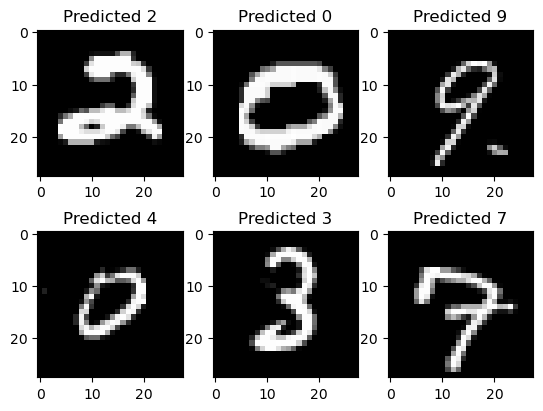

In [18]:
plt.figure()
f, axarr = plt.subplots(2, 3)
counter = 0
for i in range(2):
    for j in range(3):
        axarr[i][j].imshow(imgs[counter].squeeze(), cmap="gray")
        axarr[i][j].set_title(f"Predicted {labels[counter]}")
        counter += 1